In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from scipy.stats import norm
import numpy as np
from scipy.optimize import minimize_scalar

In [2]:
df = pd.read_csv('fuel_output.csv', sep=';')

dates = pd.to_datetime(df['Date'])

fuel_data = df['fuel_data']
logret_fuel_data = df['logret_fuel_data'][1:]
logret_fuel_data=logret_fuel_data.values

## GARCH

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002832. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


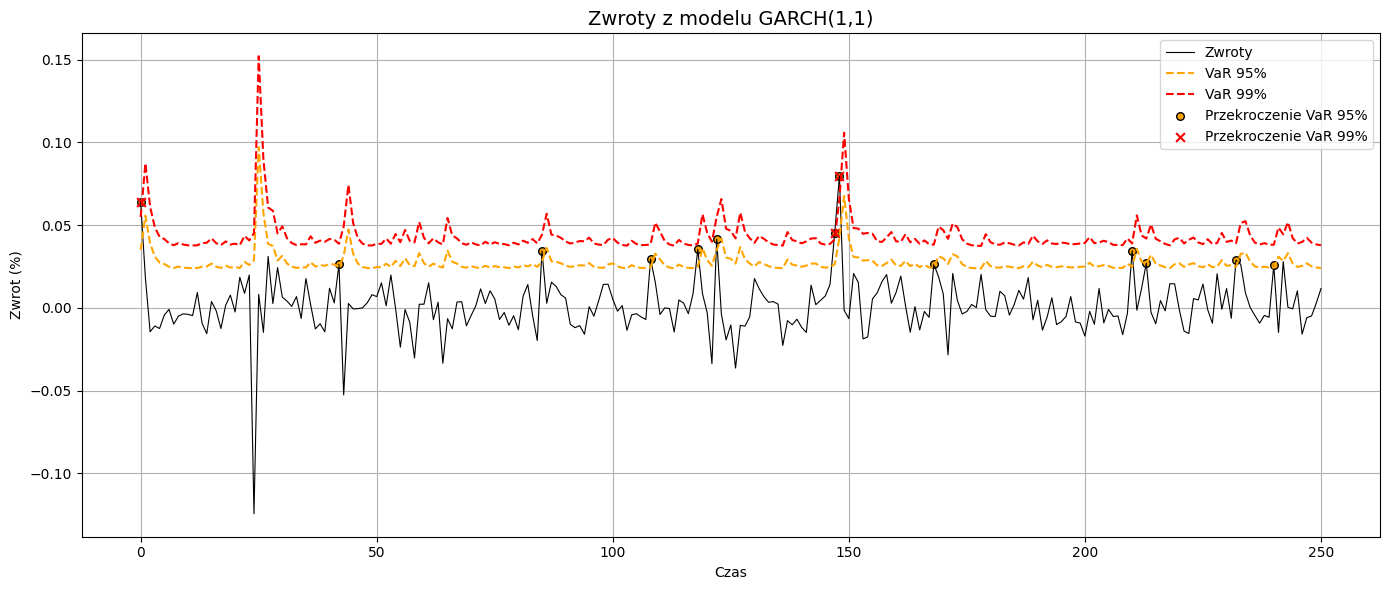

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

model = arch_model(logret_fuel_data, vol='Garch', p=1, q=1)
garch_fit = model.fit(disp="off")

mu=garch_fit.params[0]
cond_vol = garch_fit.conditional_volatility
standardized_residuals = garch_fit.resid / cond_vol

VaR95_quantile = np.quantile(standardized_residuals, 0.95)
VaR99_quantile = np.quantile(standardized_residuals, 0.99)

VaR_95 = cond_vol * VaR95_quantile+mu
VaR_99 = cond_vol * VaR99_quantile+mu

plt.figure(figsize=(14, 6))
plt.plot(logret_fuel_data, label='Zwroty', color='black', linewidth=0.8)
plt.plot(VaR_95, label='VaR 95%', color='orange', linestyle='--')
plt.plot(VaR_99, label='VaR 99%', color='red', linestyle='--')

exceed_95 = logret_fuel_data > VaR_95
exceed_99 = logret_fuel_data > VaR_99

plt.scatter(np.where(exceed_95)[0], logret_fuel_data[exceed_95],
            color='orange', label='Przekroczenie VaR 95%', marker='o', s=30, edgecolors='k')
plt.scatter(np.where(exceed_99)[0], logret_fuel_data[exceed_99],
            color='red', label='Przekroczenie VaR 99%', marker='x', s=40)

plt.title('Zwroty z modelu GARCH(1,1)', fontsize=14)
plt.xlabel('Czas')
plt.ylabel('Zwrot (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## PROGNOZA GARCH NA t+1

In [9]:
forecast = garch_fit.forecast(horizon=1)
sigma_t1 = np.sqrt(forecast.variance.values[-1, 0])
mu=forecast.mean.values[-1, 0]

# Obliczenie wartości VaR na przyszlosc
VaR_garch_95 = sigma_t1 * VaR95_quantile+mu
VaR_garch_99 = sigma_t1 * VaR99_quantile+mu

print(f"VaR 95% (ryzyko wzrostu) na t+1: {VaR_garch_95*100:.4f}%")
print(f"VaR 99% (ryzyko wzrostu) na t+1: {VaR_garch_99*100:.4f}%")

VaR 95% (ryzyko wzrostu) na t+1: 2.5526%
VaR 99% (ryzyko wzrostu) na t+1: 4.0080%


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


## WYKRESY Z BACKTESTINGU

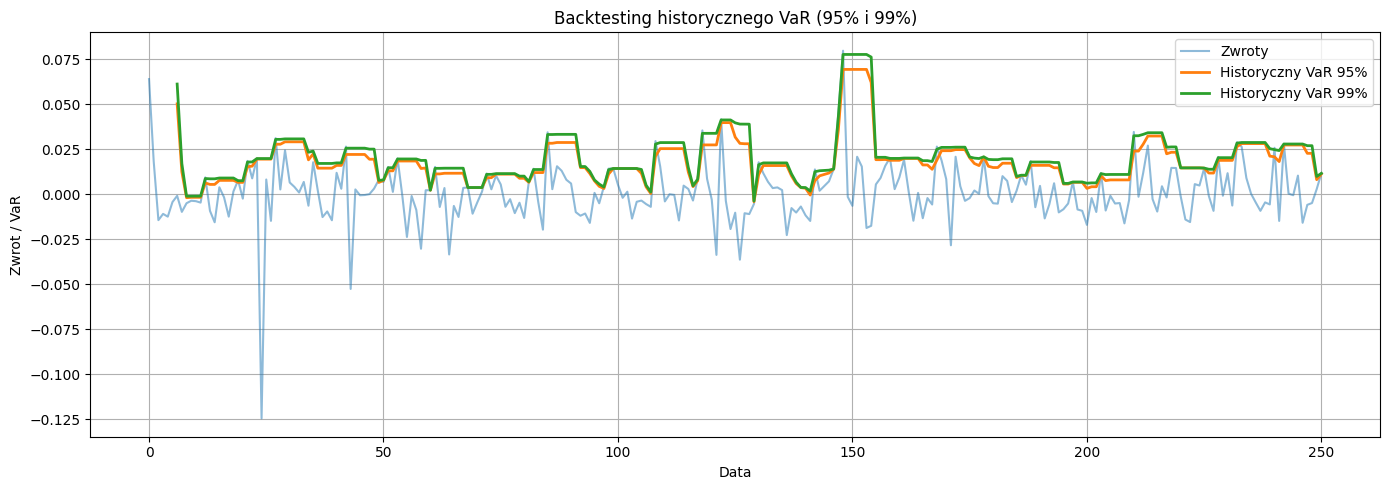

In [10]:
returns=logret_fuel_data
df = pd.DataFrame({"returns": returns})

window_size = 7  # 7 dniowe okno
conf_levels = [0.95, 0.99]

VaRs_hist = {}
for cl in conf_levels:
    VaRs_hist[cl] = df['returns'].rolling(window=window_size).quantile(cl)

plt.figure(figsize=(14, 5))
plt.plot(df.index, df['returns'], label="Zwroty", alpha=0.5)

for cl in conf_levels:
    plt.plot(df.index, VaRs_hist[cl], label=f"Historyczny VaR {int(cl * 100)}%", linewidth=2)

plt.title("Backtesting historycznego VaR (95% i 99%)")
plt.xlabel("Data")
plt.ylabel("Zwrot / VaR")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()